<a href="https://colab.research.google.com/github/joybratas1/timeseries_Exam_ISI/blob/main/TimeSeries_Assignment_ISI.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [199]:

import warnings
import itertools
import numpy as np
import pandas as pd
from pandas import read_excel
from sklearn.linear_model import LinearRegression
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import PowerTransformer


In [3]:
filename = '/content/Q2.xlsx'

In [135]:
df = read_excel(filename)

In [136]:
df.head()

,DATE,CPI
0,1997M01,76.118154
1,1997M02,77.021316
2,1997M03,71.738301
3,1997M04,76.904779
4,1997M05,76.817376


In [137]:
df['DATE'] = df['DATE'].str.replace(r'\D', '')  #Removing M from the DATE

In [138]:
df.head()

,DATE,CPI
0,199701,76.118154
1,199702,77.021316
2,199703,71.738301
3,199704,76.904779
4,199705,76.817376


In [139]:
#left = df['DATE'].str[:4]
df['DATE']=df['DATE'].str[:4] + '-' +  df['DATE'].str[4:] + '-01' 

In [140]:
pd.to_datetime(df['DATE'])

0     1997-01-01
1     1997-02-01
2     1997-03-01
3     1997-04-01
4     1997-05-01
         ...    
247   2017-08-01
248   2017-09-01
249   2017-10-01
250   2017-11-01
251   2017-12-01
Name: DATE, Length: 252, dtype: datetime64[ns]

In [141]:
df.head()

,DATE,CPI
0,1997-01-01,76.118154
1,1997-02-01,77.021316
2,1997-03-01,71.738301
3,1997-04-01,76.904779
4,1997-05-01,76.817376


In [142]:
df.set_index('DATE',inplace=True)

Text(0, 0.5, 'CPI')

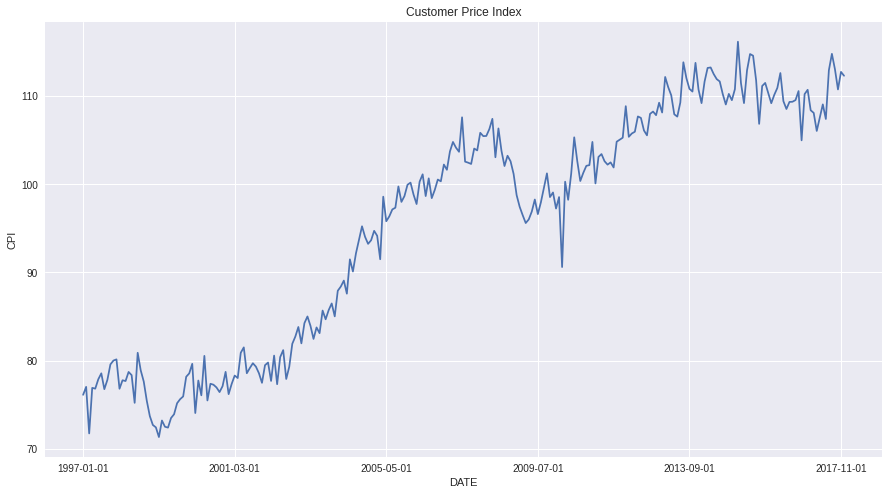

In [143]:
df['CPI'].plot(figsize=(15,8),title='Customer Price Index')
plt.ylabel('CPI')


In [144]:
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA

In [145]:
from statsmodels.tsa.stattools import adfuller
def dicky_fuller_test(x):
    result = adfuller(x, autolag='AIC')
    print('ADF Test Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Lags: %f' % result[2])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [146]:
dicky_fuller_test(df['CPI'])

ADF Test Statistic: -0.790202
p-value: 0.821983
Lags: 7.000000
Critical Values:
	1%: -3.457
	5%: -2.873
	10%: -2.573
Fail to reject the null hypothesis (H0), the data is non-stationary


For a Time series to be stationary, its ADCF test should have:

p-value to be low (according to the null hypothesis)

The critical values at 1%,5%,10% confidence intervals should be as close as possible to the Test Statistics

Log Transform


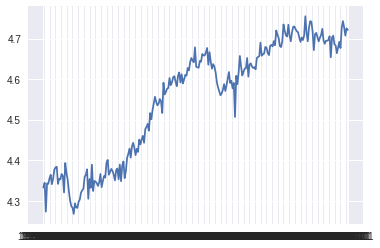

In [147]:
df_logScale = np.log(df)
plt.plot(df_logScale)

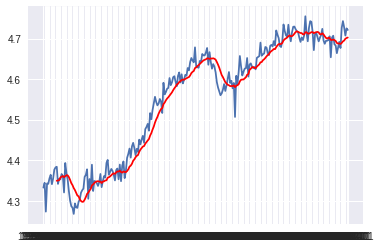

In [148]:
movingAverage = df_logScale.rolling(window=12).mean()
movingSTD = df_logScale.rolling(window=12).std()
plt.plot(df_logScale)
plt.plot(movingAverage, color='red')

In [149]:
datasetLogScaleMinusMovingAverage = df_logScale - movingAverage
datasetLogScaleMinusMovingAverage.head(12)

#Remove NAN values
datasetLogScaleMinusMovingAverage.dropna(inplace=True)
datasetLogScaleMinusMovingAverage.head(10)

,CPI
DATE,
1997-12-01,0.034622
1998-01-01,-0.008583
1998-02-01,0.003051
1998-03-01,-0.004706
1998-04-01,0.006524
1998-05-01,0.000300
1998-06-01,-0.037779
1998-07-01,0.032609
1998-08-01,0.005401


In [152]:
dicky_fuller_test(datasetLogScaleMinusMovingAverage['CPI'])

ADF Test Statistic: -5.307805
p-value: 0.000005
Lags: 1.000000
Critical Values:
	1%: -3.458
	5%: -2.874
	10%: -2.573
Reject the null hypothesis (H0), the data is stationary.


In [154]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.arima_model import ARIMA

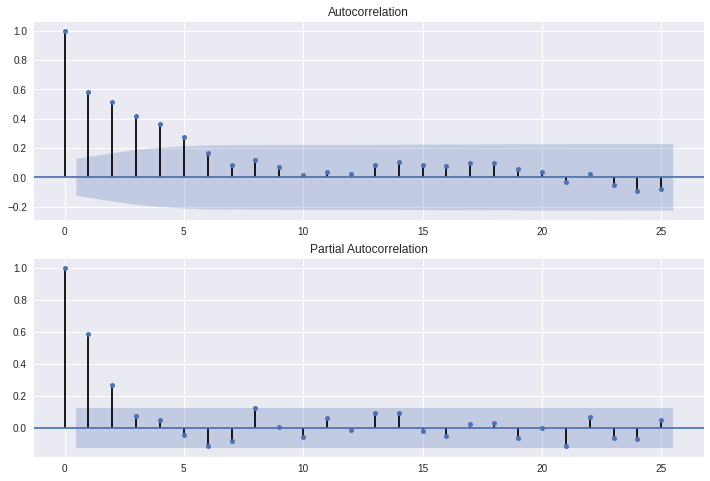

In [179]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasetLogScaleMinusMovingAverage['CPI'], lags=25, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasetLogScaleMinusMovingAverage['CPI'], lags=25, ax=ax2)

It can be seen that Both ACF and PACF show slow decay (gradual decrease)

p is 5
q is 3 

In [204]:
from statsmodels.tsa.stattools import acf ,pacf
lag_acf= acf(datasetLogScaleMinusMovingAverage['CPI'], nlags=25)
lag_pacf = pacf(datasetLogScaleMinusMovingAverage['CPI'], nlags =25, method='ols')

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


There is a Gradual decrease for both ACF and PACF plots.

In [217]:
import numpy as np
import scipy.stats
def sac(x, k=1):
 """
 Sample autocorrelation (As used in statistics with normalization)
 http://en.wikipedia.org/wiki/Autocorrelation
 Parameters
 ----------
 x : 1d numpy array
 Signal
 k : int or list of ints
 Lags to calculate sample autocorrelation for
 Returns
 -------
 res : scalar or np array
 The sample autocorrelation. A scalar value if k is a scalar, and a
 numpy array if k is a interable.
 """
 try:

  res = []
  for ki in k:
    res.append(sac(x, ki))
  return np.array(res)
 except:
    pass
 mx = np.mean(x)
 if k==0:
  N = np.sum((x-mx)*(x-mx))
 else:
  N = np.sum((x[:-k]-mx)*(x[k:]-mx))
  D = len(x) * np.var(x)
  return N/D
def ljungbox(x, lags, alpha=0.1):
 """
 The Ljung-Box test for determining if the data is independently distribu
 Parameters
 ----------
 x : 1d numpy array
 Signal to test
 lags : int
 Number of lags being tested

 Returns
 -------
 Q : float
 Test statistic
 """
 n = len(x)
 Q = 0
 for k in range(1, lags+1):
  Q += (sac(x, k)**2) / (n-k)
  Q = n*(n+2)*Q
 return Q
def boxpierce(x, lags, alpha=0.1):
 """
 The Box-Pierce test for determining if the data is independently distrib
 Parameters
 ----------
 x : 1d numpy array
 Signal to test
 lags : int
 Number of lags being tested

 Returns
 -------
 Q : float
 Test statistic
 """
 n = len(x)
 Q = 0
 for k in range(1, lags+1):
  Q += (sac(x, k)**2)
  Q = n*Q
  return Q
def lbqtest(x, lags, alpha=0.1, method='lb'):
 """
 The Ljung-Box test for determining if the data is independently distribu
 Parameters
 ----------
 x : 1d numpy array
 Signal to test
 lags : list of ints
 Lags being tested
 alpha : float
 Significance level used for the tests
 method : string
 Can be either 'lb' for Ljung-Box, or 'bp' for Box-Pierce

 Returns
 -------
 h : np array
 Numpy array of bool values, True == H0 hypothesis rejected
 pV : np array
 Test statistics p-values
 Q : np array
 Test statistics
 cV : np array
 Critical values used for determining if H0 should be rejected. The
 critical values are calculated from the given alpha and lag.
 """
 if method=='lb':
  findq = ljungbox
 else:
  findq = boxpierce
 n = len(x)
 Q = np.zeros(len(lags))
 pV = np.zeros(len(lags))
 cV = np.zeros(len(lags))
 for i, lag in enumerate(lags):
  Q[i] = findq(x, lag)
  pV[i] = 1.0 - scipy.stats.chi2.cdf(Q[i], lag)
  cV[i] = scipy.stats.chi2.ppf(1-alpha, lag)
 h = Q>cV
 return h, pV, Q, cV


In [223]:
h, pV, Q, cV = lbqtest(df['CPI'],range(1, 30),alpha=0.1)
print ('lag p-value Q c-value rejectH0')
for i in range(len(h)):
 print ("%-2d %10.3f %10.3f %10.3f %s" % (i+1, pV[i], Q[i], cV[i], str(h[i])))

lag p-value Q c-value rejectH0
1       0.000    247.584      2.706 True
2       0.000 15847585.182      4.605 True
3       0.000 1014372232541.653      6.251 True
4       0.000 64927937860526328.000      7.779 True
5       0.000 4155907446576569122816.000      9.236 True
6       0.000 266011323840473053177839616.000     10.645 True
7       0.000 17026852816380998687529367502848.000     12.017 True
8       0.000 1089854795070914970062232052817723392.000     13.362 True
9       0.000 69759425722899127853470962225385293479936.000     14.684 True
10      0.000 4465161321671327640254652747372495624751546368.000     15.987 True
11      0.000 285806045877538343116417879287383518503945078046720.000     17.275 True
12      0.000 18293873384529474636385672443525914856110782843690418176.000     18.549 True
13      0.000 1170954247596962556229459338365147362729243934747203383328768.000     19.812 True
14      0.000 74950439480186378173036803785074006238585815879647331554120695808.000     21.064 Tr

### We can infer that the series has no white noise

In [182]:
import statsmodels.api as sm

res = sm.tsa.ARMA(datasetLogScaleMinusMovingAverage['CPI'], (1,1)).fit(disp=-1)
#perform Ljung-Box test on residuals with lag=5
sm.stats.acorr_ljungbox(res.resid, lags=[5])

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


(array([2.28396952]), array([0.80861842]))

In [189]:
import scipy

In [226]:
from math import sqrt
X = datasetLogScaleMinusMovingAverage['CPI'].values
X = X.astype('float32')
train_size = int(len(X) * 0.50)
train, test = X[0:train_size], X[train_size:]
# walk-forward validation
history = [x for x in train]
predictions = list()
for i in range(len(test)):
	# predict
	model = ARIMA(history, order=(0,1,1))
	model_fit = model.fit()
	yhat = model_fit.forecast()[0]
	predictions.append(yhat)
	# observation
	obs = test[i]
	history.append(obs)
	print('>Predicted=%.3f, Expected=%.3f' % (yhat, obs))
# report performance
rmse = sqrt(mean_squared_error(test, predictions))
print('RMSE: %.3f' % rmse)

>Predicted=0.003, Expected=0.019
>Predicted=0.011, Expected=0.012
>Predicted=0.012, Expected=0.011
>Predicted=0.011, Expected=0.017
>Predicted=0.014, Expected=0.025
>Predicted=0.020, Expected=-0.016
>Predicted=0.002, Expected=0.017
>Predicted=0.009, Expected=-0.008
>Predicted=0.000, Expected=-0.025
>Predicted=-0.012, Expected=-0.014
>Predicted=-0.014, Expected=-0.019
>Predicted=-0.017, Expected=-0.031
>Predicted=-0.024, Expected=-0.049
>Predicted=-0.038, Expected=-0.056
>Predicted=-0.048, Expected=-0.059
>Predicted=-0.054, Expected=-0.059
>Predicted=-0.057, Expected=-0.046
>Predicted=-0.052, Expected=-0.031
>Predicted=-0.041, Expected=-0.011
>Predicted=-0.025, Expected=-0.022
>Predicted=-0.024, Expected=-0.005
>Predicted=-0.014, Expected=0.015
>Predicted=0.002, Expected=0.033
>Predicted=0.020, Expected=0.008
>Predicted=0.013, Expected=0.013
>Predicted=0.013, Expected=-0.005
>Predicted=0.003, Expected=0.006
>Predicted=0.004, Expected=-0.073
>Predicted=-0.039, Expected=0.024
>Predicted=-

In [248]:
arima_mod6 = sm.tsa.ARIMA(datasetLogScaleMinusMovingAverage['CPI'], (5,1,3)).fit(disp=False)
print(arima_mod6.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.CPI   No. Observations:                  240
Model:                 ARIMA(5, 1, 3)   Log Likelihood                 604.038
Method:                       css-mle   S.D. of innovations              0.019
Date:                Wed, 14 Jul 2021   AIC                          -1188.077
Time:                        13:06:11   BIC                          -1153.270
Sample:                    01-01-1998   HQIC                         -1174.052
                         - 12-01-2017                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -1.921e-05   6.33e-05     -0.304      0.762      -0.000       0.000
ar.L1.D.CPI    -0.3587      0.066     -5.416      0.000      -0.488      -0.229
ar.L2.D.CPI    -0.4199      0.067     -6.245    

NormaltestResult(statistic=8.51548451006009, pvalue=0.014154222988097454)


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


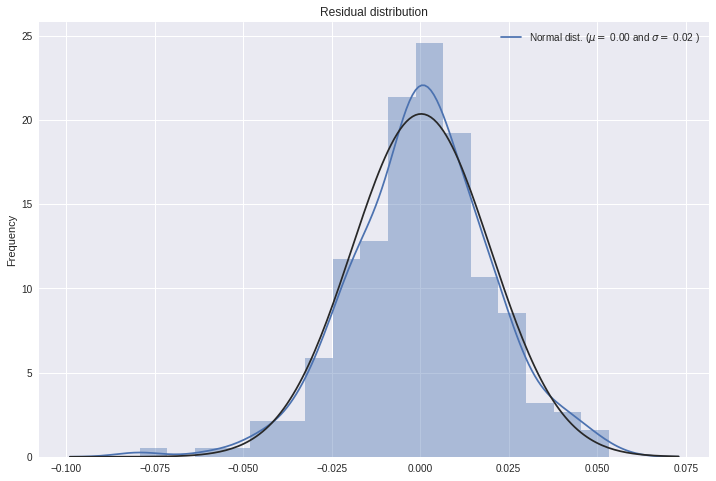

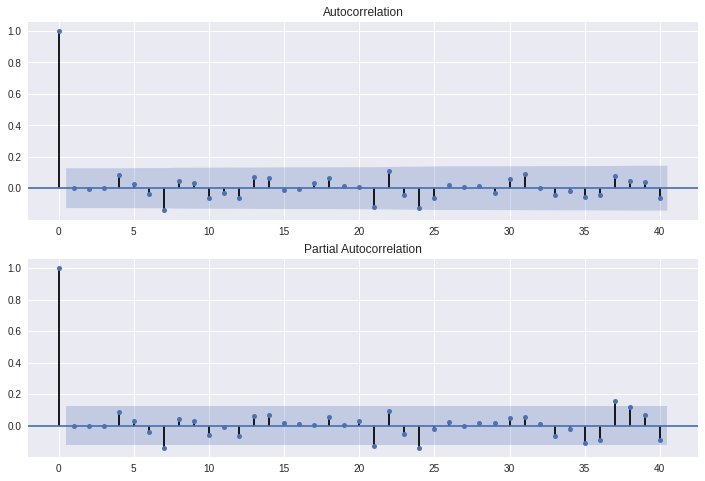

In [249]:
from scipy import stats
from scipy.stats import normaltest

resid = arima_mod6.resid
print(normaltest(resid))
# returns a 2-tuple of the chi-squared statistic, and the associated p-value. the p-value is very small, meaning
# the residual is not a normal distribution

fig = plt.figure(figsize=(12,8))
ax0 = fig.add_subplot(111)

sns.distplot(resid ,fit = stats.norm, ax = ax0) # need to import scipy.stats

# Get the fitted parameters used by the function
(mu, sigma) = stats.norm.fit(resid)

#Now plot the distribution using 
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)], loc='best')
plt.ylabel('Frequency')
plt.title('Residual distribution')


# ACF and PACF
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(arima_mod6.resid, lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(arima_mod6.resid, lags=40, ax=ax2)

In [250]:
sm.stats.acorr_ljungbox(resid, lags=[20])   #LJung Test

(array([13.94064657]), array([0.83349249]))

### Hence the model performs well as the ARIMA is more or less normally distributed and ACF, PACF has no significat value.

* The Ljung-Box test showed that there is little evidence of non-zero autocorrelations in the in sample forecast errors,and the distribution of forecast errors seems to be normally distributed
with mean zero. This suggests that the simple exponential smoothing method provides an adequate p
redictive model for usage. Furthermore, the assumptions that the 80% and 95% predictions interval
s were based upon (that there are no autocorrelations in the forecast errors, and the forecast er
rors are normally distributed with mean zero and constant variance) are probably valid.

In [251]:
predictions_ARIMA_diff = pd.Series(arima_mod6.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

DATE
1998-01-01   -0.000019
1998-02-01    0.017836
1998-03-01    0.001698
1998-04-01    0.005273
1998-05-01   -0.001512
dtype: float64


In [252]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum)

DATE
1998-01-01   -0.000019
1998-02-01    0.017816
1998-03-01    0.019514
1998-04-01    0.024787
1998-05-01    0.023275
                ...   
2017-08-01   -0.060263
2017-09-01   -0.082909
2017-10-01   -0.085919
2017-11-01   -0.075215
2017-12-01   -0.084762
Length: 240, dtype: float64


In [253]:
predictions_ARIMA_log = pd.Series(datasetLogScaleMinusMovingAverage['CPI'].iloc[0], index=datasetLogScaleMinusMovingAverage.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA_log.head()

DATE
1997-12-01    0.034622
1998-01-01    0.034603
1998-02-01    0.052439
1998-03-01    0.054136
1998-04-01    0.059410
dtype: float64

### Forecasting the next 5 periods(5*12)

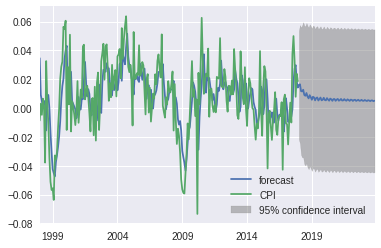

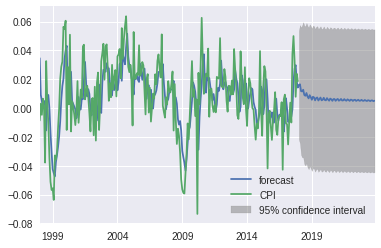

In [256]:
arima_mod6.plot_predict(1,311)